# A simulation that targets a specific outcome

In normal model use, the trajectory of the exogenous variables determine the trajectory of the endogenous (left hand side) variables. However, sometimes  it can be useful to target a trajectory of some endogenous variables by calculating a trajectory of exogenous variables. 

A simple example might be where a policy maker wanted to know what level of Carbon Tax implemented in a budget neutral fashion would be needed to achieve a specific level of emissions.  As specified, the analytical question is to achieve two targets: 

 1. A specific $CO^2$ emissions trajectory 
 2. An unchanged fiscal deficit 
 
The implemntation of targetting in `Modelflow` requires that there be as many instruments as there are targets. So in the above example two instruments would be required. 

The instrument to achieve the emissions could be a Carbon tax (applied uniformly on emissions from coal, gas and crude oil).  The instrument to achieve an unchanged fiscal deficit, could be government spending or another from of revenue, say taxes on labor.

 
In the example below the two instruments are the:
 
 1. Carbon emission tax, which is covered by 3 variables 
 2. Government capital expenditure
 
 
# Preparing the work space  

As always before running a simulation, the various python classes that will be used must be imported.

In [25]:
# HIDDEN in jupyterbook 
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')
  incolab = True  
else:
  incolab = False 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
%matplotlib inline

In [27]:
from modelclass import model 

model.widescreen()
model.scroll_off()

# Targeting carbon emissions in a budget neutral manner
 
To run the simulation, the following main steps must be undertaken

1. Load a model and data
2. Create an baseline 
3. Define instrument variables (one instrument can consist of several variables). 
4. Define a dataframe with the trajectory of the target variables.  
3. Solve the problem by using the `.invert` method. 
4. Visualize the results 

This Notebook uses a  model for Pakistan described here: {cite:author}`burns_climate_2021`

## Load a  model, data and descriptions 
The file `pak.pcim` contains a dump of model equations, dataframe, simulation options and variable descriptions. The file has been created when onboarding the model. The onboarding process is described [here.](../../onboard/eviews/onboard%20one%20model%20from%20%20wf1.html#onboard-a-model-defined-in-a-wf1-file)

In [28]:
mpak,initial = model.modelload('../models/pak.pcim')

file read:  C:\mflow\Aug23\papers\mfbook\content\models\pak.pcim


## Solve the model to create a baseline

In [29]:
baseline = mpak(initial,2022,2100,alfa=0.7,silent=1,ljit=False,stringjit=False)
mpak.basedf = baseline.copy()


## Target CO2 emission and government deficit by adjusting carbon tax and government expenditure. 

As indicated above this scenario has two targets.  The first is to reduce carbon emissions by 75% by 2050 and then hold them at that level. The instrument to be employed will be a Carbon tax.  The second target is that the government budget remains unchanged.  The instrument to be used here is government spending on goods and services, implying that revenues from the Carbon Taxes will be used to increase government services.  {cite:author}`burns_climate_2021` using the same model explores the macroeconomic consequences implications of alternative uses of the revenues from the Carbon Tax.



### Define target trajectory for CO2 emission. 
The objective is to reduce Carbon emissions by 75% (as compared with the baseline) by the year 2050 and hold them constant in level terms afterwards.  

In [43]:
reduction_percent = 60   # Input the desired reduction in percent. 
achieve_red_by=2050

To implement this, one must:


 1. Calculate the target emission in 2050 = $PAKCCEMISCO2TKN_{achieve\_red\_by} (1-reduction\_percent/100)$ 
 2. Calculate the yearly growth rate of the target variable needed to reach that level:  $\dfrac{Target_{achieve\_red\_by}}{PAKCCEMISCO2TKN_{2024}}^{\frac{1}{achieve\_red\_by-2024}}-1$
 3. Calculate target values for emission in each year and then hold them constant from 2050 through 2100




In [44]:
bau_2050        = baseline.loc[2050,'PAKCCEMISCO2TKN']
bau_2024        = baseline.loc[2024,'PAKCCEMISCO2TKN']

target_2050 = bau_2050*(1-reduction_percent/100)


target_growth_rate = (target_2050/bau_2024)**(1/(2050-2024))-1
bau_growth_rate = (bau_2050/bau_2024)**(1/(2050-2024))-1

print(f"Business as usual Emission value in 2050: {bau_2050:13,.0f} tons")
print(f"Target  Emission value in 2050          : {target_2050:13,.0f} tons")
print(f"Business as usual growth rate in percent: {bau_growth_rate:13,.1%}")
print(f"Target growth rate in percent           : {target_growth_rate:13,.1%}")

Business as usual Emission value in 2050:   439,930,556 tons
Target  Emission value in 2050          :   175,972,222 tons
Business as usual growth rate in percent:          2.5%
Target growth rate in percent           :         -1.0%


#### Create a dataframe with the target emission 
Now a dataframe can be created using the growth rate for the target variable calculated above. 

The dataframe should only contain columns for the target variables, at this stage just one. 

In [45]:
target_before = baseline.loc[2024:,['PAKCCEMISCO2TKN']]     # Create dataframe with only the target variable 
# create a target dataframe with a projection of the target variable 
target = target_before.upd(f'<2025 2050> PAKCCEMISCO2TKN =growth {100*target_growth_rate}')
target=target.upd(f'<2051 2100> PAKCCEMISCO2TKN = {target_2050}')
#target.loc[2040:2055]

### Create target for government deficit 
This is done simply by taking the values in the baseline for the relevant years. 

In [46]:
target.loc[:,'PAKGGBALOVRLCN'] = baseline.loc[2022:2100,'PAKGGBALOVRLCN']

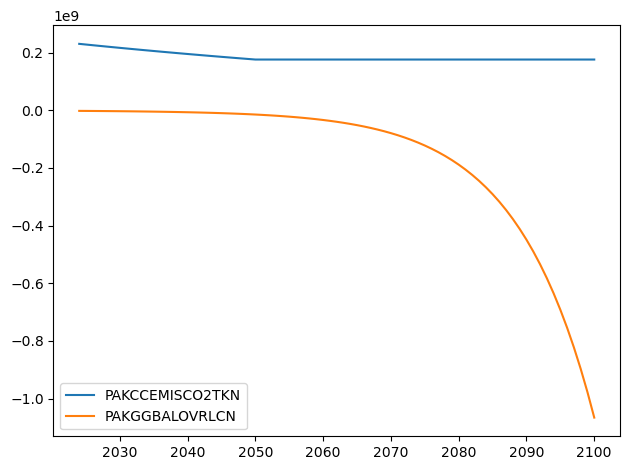

In [47]:
target.plot();

## Define instruments

The instruments to be used are the carbon tax and government spending on goods and services.  To find the mnemonics for these variables a search is done over the descriptions of the variables, first over the carbon tax:

In [35]:
mpak['!*Carbon*'].des

PAKGGREVCO2CER : Carbon tax on coal (USD/t)
PAKGGREVCO2GER : Carbon tax on gas (USD/t)
PAKGGREVCO2OER : Carbon tax on oil (USD/t)


Note there are three Carbon taxes so each will be considered and instrument.

A separate search is done to identify the government spending variable to be used as an instrument to ensure that the fiscal deficit remains unchanged.
and then on government spending

In [36]:
mpak['!*expenditure*'].des

PAKGGEXPCAPTCN        : General government expenditure on capital expenditure (millions lcu)
PAKGGEXPCAPTCN_A      : Add factor:General government expenditure on capital expenditure (millions lcu)
PAKGGEXPCAPTCN_D      : Fix dummy:General government expenditure on capital expenditure (millions lcu)
PAKGGEXPCAPTCN_FITTED : Fitted  value:General government expenditure on capital expenditure (millions lcu)
PAKGGEXPCAPTCN_X      : Fix value:General government expenditure on capital expenditure (millions lcu)
PAKGGEXPCRNTCN        : Current Expenditures
PAKGGEXPGNFSCN        : General government expenditure on goods and services (millions lcu)
PAKGGEXPGNFSCN_A      : Add factor:General government expenditure on goods and services (millions lcu)
PAKGGEXPGNFSCN_D      : Fix dummy:General government expenditure on goods and services (millions lcu)
PAKGGEXPGNFSCN_FITTED : Fitted  value:General government expenditure on goods and services (millions lcu)
PAKGGEXPGNFSCN_X      : Fix value:General 

There are many government spending lines, for the purposes of this experiment the `PAKGGEXPGNFSCN_A` variable (the add-factor for the government spending on goods and services equation) is selected.

In [37]:
instruments = [['PAKGGREVCO2CER','PAKGGREVCO2GER', 'PAKGGREVCO2OER'],
               'PAKGGEXPGNFSCN_A']

In total there are four instruments and two targets, which satisfies the constraint that there must be at least as many instruments as targets.
 

### Now solve the problem: 

Now we have a dataframe with target values and a list of instrument variables. We are ready to solve the problem. 

In [38]:
%%time
_ = mpak.invert(baseline,                  # Invert calls the target instrument device                   
                targets = target,                   
                instruments=instruments,
                DefaultImpuls=20,              # The default impulse instrument variables 
                defaultconv=2.0,              # Convergergence criteria for targets
                varimpulse=False,             # Changes in instruments in each iteration are carried over to the future
                nonlin=5,                    # If no convergence in 15 iteration recalculate jacobi 
                silent=1,                     # Don't show iteration output (try 1 for showing)
                delay=0,
               maxiter = 2590)

Finding instruments :   0%|          | 0/77

CPU times: total: 31min 55s
Wall time: 32min 8s


### Make a graph and decorate with a line and an annotation
Also show the tax rate



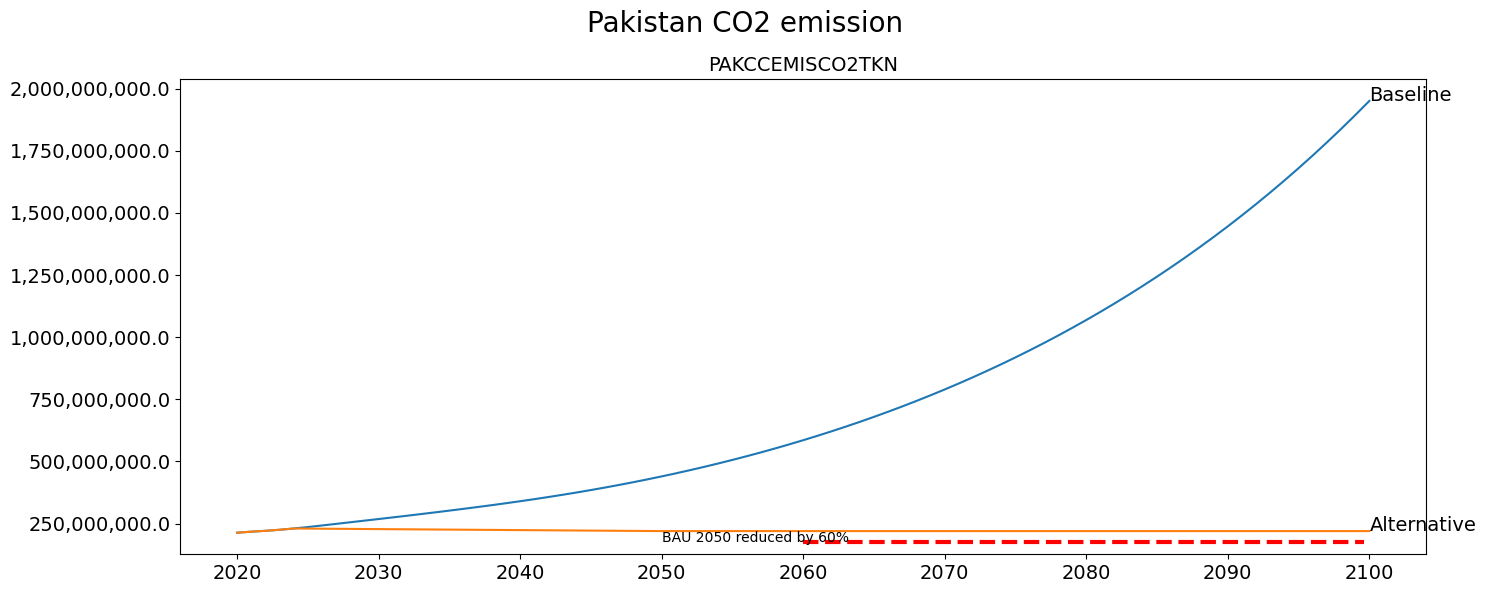

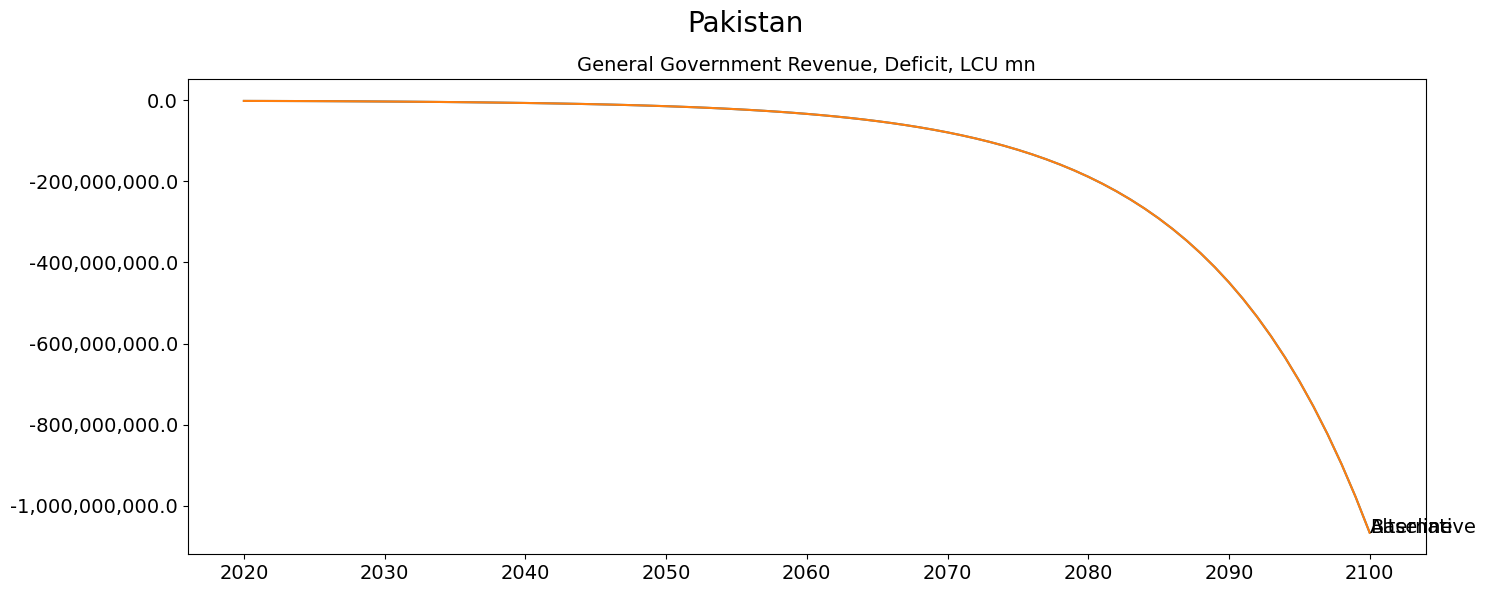

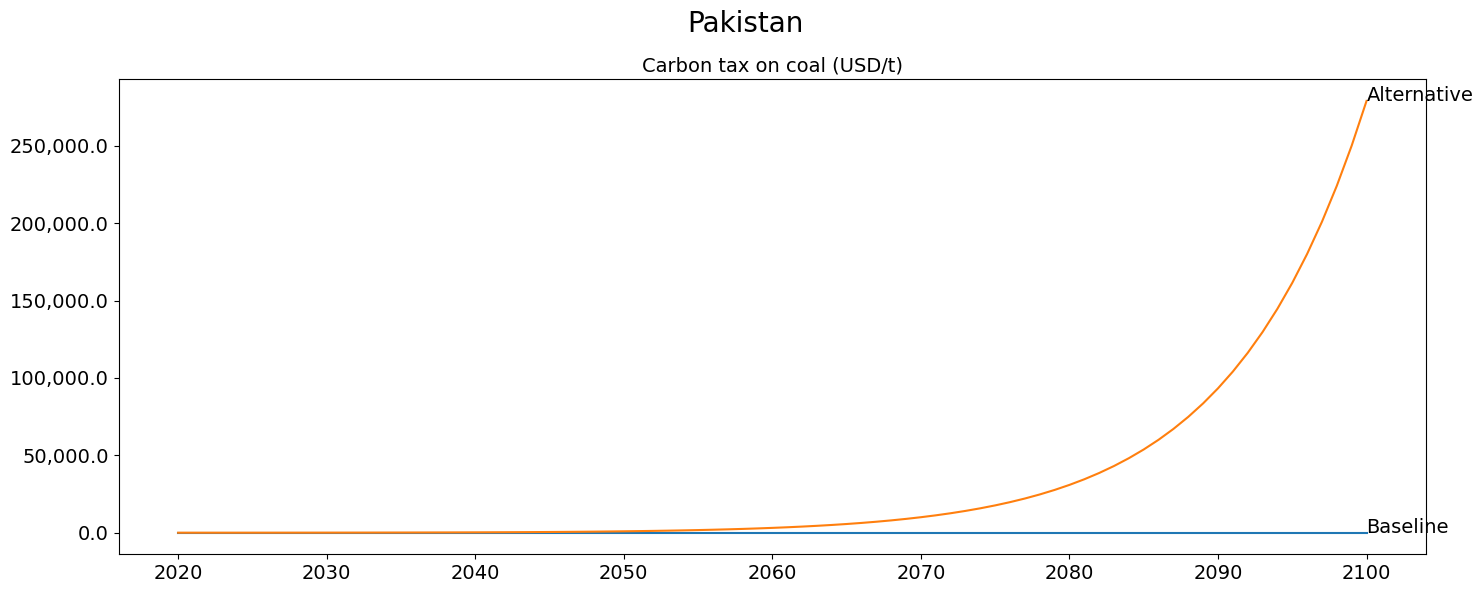

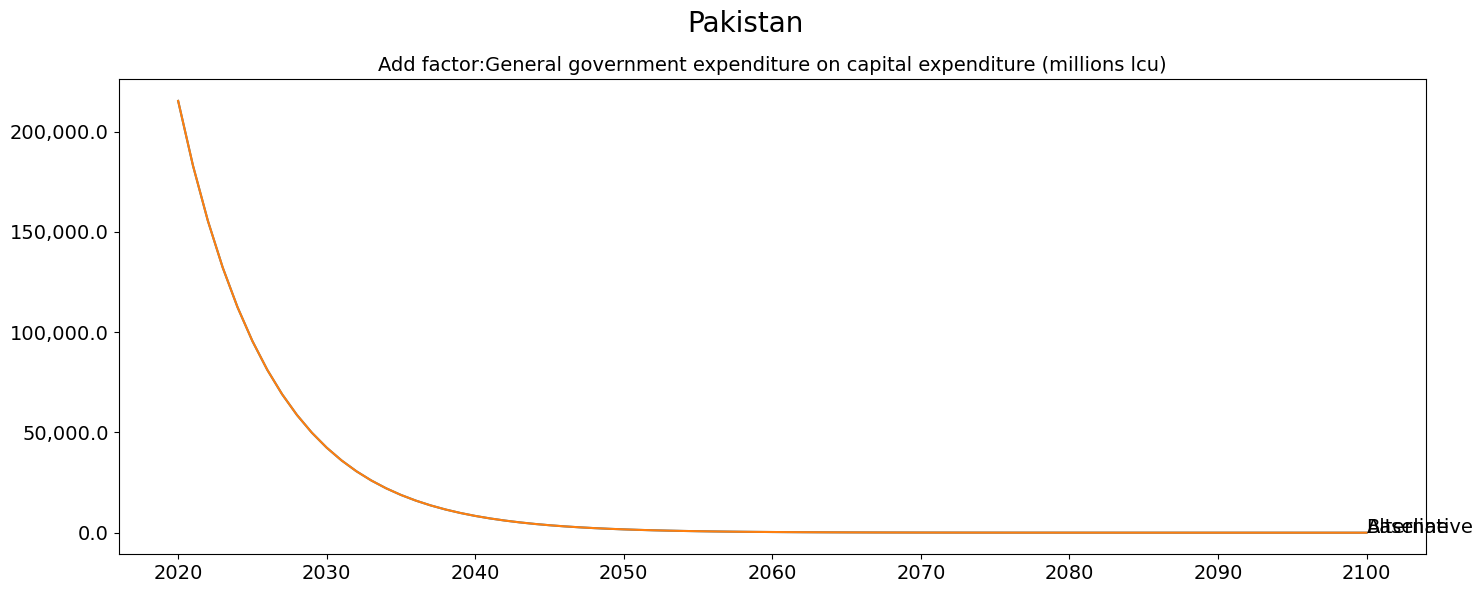

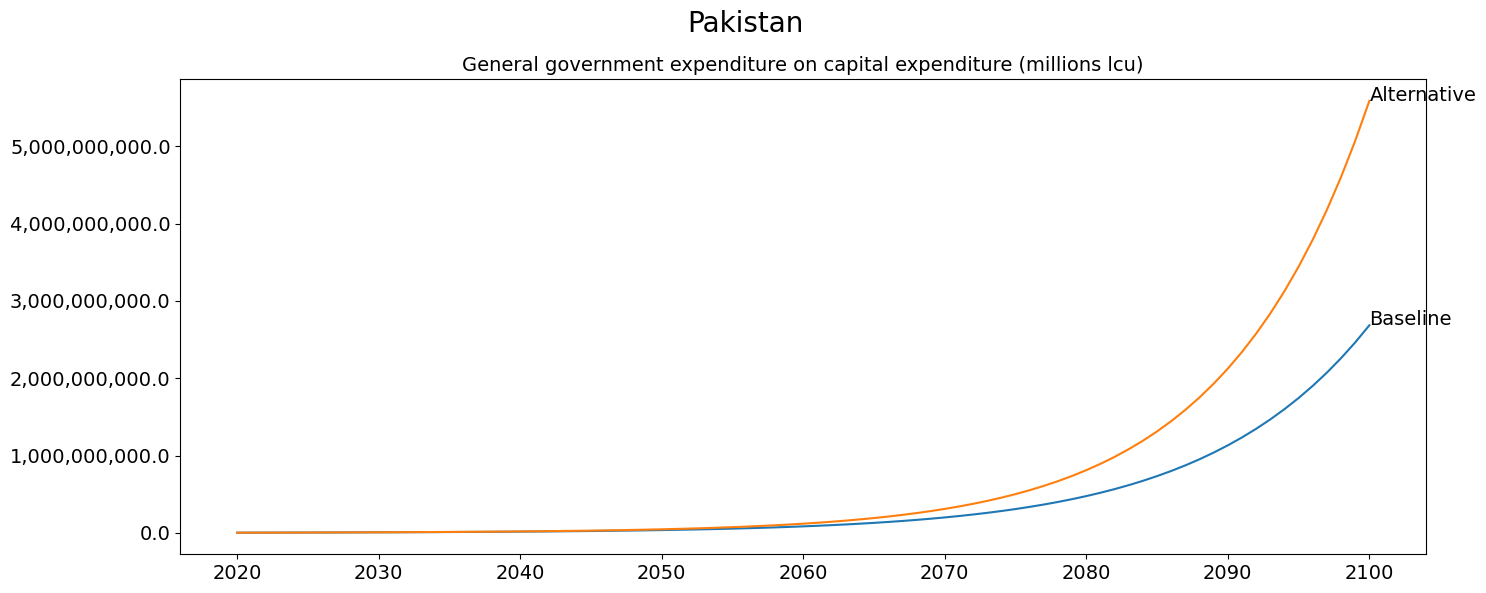

In [48]:
with mpak.set_smpl(2020,2100):    # change if you want another  timeframe 
    fig = mpak[f'PAKCCEMISCO2TKN' ].plot_alt(title='Pakistan CO2 emission')
    fig.axes[0].axhline( target_2050,
                                  xmin=0.5,
                                  xmax = 0.95,
                                  linewidth=3, 
                                  color='r', ls='dashed')

    fig.axes[0].annotate(f'BAU 2050 reduced by {reduction_percent}%', xy=(2050,target_2050 ))
    fig0 = mpak[f'PAKGGBALOVRLCN' ].plot_alt(title=f'Pakistan'); 
    fig2 = mpak[f'PAKGGREVCO2CER' ].plot_alt(title=f'Pakistan'); 
    fig3 = mpak[f'PAKGGEXPCAPTCN_A' ].plot_alt(title=f'Pakistan'); 
    fig4 = mpak[f'PAKGGEXPCAPTCN' ].plot_alt(title=f'Pakistan'); 


### Look at selected variables with the [] operator 
If you want to look at multiple variables the index [] operator can be used to select the variables to analyze/visualize. Here only a few operations will be shown. There is more [here](index-operator)

In [41]:
mpak['PAKNYGDPMKTPKN PAKNECONGOVTKN PAKNEGDIFTOTKN PAKNEIMPGNFSKN PAKCCEMISCO2TKN']